# Tanzania Water Wells
Predicting the operating condition of water wells in Tanzania based on variaous predictive models.

By: Anat Jacobson 

--- 

### Overview 

This project is based on data on the on the makeup and condition of wells within Tanzania. The data is used to create a predictive model and provide valuable insights into whether a well is in operating or not. This can aid the Tanzanian Government in deciding which wells neeed to be visited first in order to repair and aid in the major water crisis the country is facing.

### Introduction and Busines Case
The problem being faced is that there are thousands of water wells within Tanzania and many of need reparations. This is a major issue within Tanzania since wells are the main water source, so lacking functional wells is a severe threat to livelihood. Water scarcity is also effecting livestock, wild animals, fishing, and other living organisms. Additionally, as you know there has been fast population growth within the country, climate change impacts and expansion of human economic activities put the country under water supply distress. 

The issue here is that inspecting these wells cost a lot of money and takes loads of time that Tanzania does not have. I have created a model with the goal in mind to predict which wells in Tanzania are no longer functional and therefore are the ones that should be visited first and repaired.  


The data for this notebook has been provided by:  Taarifa and Tanzania Ministry of Water through <a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/" >Driven Data</a>.

### Business Understandings

#### Applications
- Tanzanian Goverment can make informed decision when deciding which well to look at to repair next and save money
- Well builders may be able to make better decisions when building and repairing wells  wells to build with parts that don't lead to breakage as much.

#### Data 
The dataset that was worked with after cleaning had over 53K wells in it with data that focused on the geographical information of the well as well as information of water source, payments, quality of water and other important features. 

The predictive measure in this set was whether the well is functional or not, positive being functional. The measure was initially in a seperate dataframe but was merged with the rest of the data to be able to accurately create a model. This cleaning and merging process is explained below. 

A few key metrics taken into account from this dataset were: 

- 5 Different quality groups of water
- 26 regions
- 1.8K funders
- 7 Source types

Additionally, the predictive measure was initailly a tirtiary measure and I changed it to binary that will be explained below as well. 

### Methodology
Because of the many categorical features that can influence well functionality pricing, this project investigates features and their effects through various types of models in an attempt to best predict the well condition. This is done through the use of logistic regression, decision trees and random forest. Our predictor for this model is whether the well is functioning or not, positive class being functional. Our measure for this project will be based on the highest f1 score since for the purposes of this project, we not only care whether the prediction is positive cases but also whether they are accurately positive and whether negative results are accurately negative. 

---

## Data Exploration and Analysis
Importing all packages needed and creating cross validation class. This class has been adapted from class lectures and the Flatiron school. 

In [433]:
#imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.pipeline import Pipeline as ImPipeline

In [434]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring = 'f1')
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} f1 score
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Import CSVs, Merge, and Clean all Data Needed
2 Datasets imported: 
- labels: contains all the lables of the dataset (ie the y variable) and ID
- df: contains all the features of the well and ID.

Will be merging these 2 dataframes to create one full set to test and train on. 

In [435]:
labels = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
#dataset with the ys of training data
df = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
#dataset with training set


In [436]:
#checking the shape of both dataframes
print('df: ', df.shape)
print('labels: ',labels.shape)

df:  (59400, 40)
labels:  (59400, 2)


Based on these 2 shapes you can see that the data is likely the same data and will be ok to merge. Looking at the heads of the data to continue observations! 

In [437]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [438]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [439]:
df.loc[df['id'] != labels['id']] #always equal. Confirming this is a quick merge! 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [440]:
#merging the dataframes
full_df = df.merge(labels)
full_df.shape

(59400, 41)

In [441]:
#checking accurate merge with a few specific ids
full_df.loc[full_df['id'] == 69572] 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [442]:
#looking into the classes of the y
full_df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

After exploring the Y class, noting that there are 3 categories: functional, non functional, and functional but needs repair. In the next few lines of codes I will be changing the y classes to be 2 classes instead of three. Grouping now by functional and non functional. Functional but needs repair now going to be considered just functional.

In [443]:
#grouping the values and checking the columns grouped correctly
full_df['status'] = np.where(full_df['status_group'] == "functional needs repair", 
                                'functional', full_df['status_group'])
full_df['status'].value_counts()

functional        36576
non functional    22824
Name: status, dtype: int64

Note here that there is currently no class imbalence which will be important when begininning models! 

In [444]:
#creating binary grouping
full_df['binary_status'] = np.where(full_df['status'] == 'functional', 1, 0)
full_df['binary_status'].value_counts()

1    36576
0    22824
Name: binary_status, dtype: int64

Now that we have binary y variable, we will continue with data cleaning process.
- Looking into NAs
- Looking into specific columns
- Dropping columns deemed unnecessary for purposes of this projects (i.e. repetitive columns, columns missing majority values, columns without explanations as to what they are showing)

In [445]:
full_df.isna().sum() #noting lots of NAs in some of these columns

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [446]:
full_df['scheme_management'].value_counts() 
#going to drop this since lots of other groupings and "company" or private operater

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [447]:
#creating new dataframe that is dropping unnesseasary columns and continuing cleaning from here
clean_df = full_df.drop(['status', 'status_group', 'waterpoint_type', 'source', 'payment_type', 
              'date_recorded', 'water_quality', 'quantity', 'num_private', 
                         'management_group', 'extraction_type_group', 
                         'extraction_type', 'recorded_by', 'latitude',
                        'longitude', 'lga', 'ward', 'scheme_name',
                        'region', 'subvillage', 'basin', 'wpt_name', 'public_meeting',
                        'gps_height', 'scheme_management'], axis = 1)

In [448]:
clean_df.head(10) #looking at new dataframe

,id,amount_tsh,funder,installer,region_code,district_code,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,binary_status
0,69572,6000.0,Roman,Roman,11,5,109,False,1999,gravity,vwc,pay annually,good,enough,spring,groundwater,communal standpipe,1
1,8776,0.0,Grumeti,GRUMETI,20,2,280,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,1
2,34310,25.0,Lottery Club,World vision,21,4,250,True,2009,gravity,vwc,pay per bucket,good,enough,dam,surface,communal standpipe,1
3,67743,0.0,Unicef,UNICEF,90,63,58,True,1986,submersible,vwc,never pay,good,dry,borehole,groundwater,communal standpipe,0
4,19728,0.0,Action In A,Artisan,18,1,0,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,1
5,9944,20.0,Mkinga Distric Coun,DWE,4,8,1,True,2009,submersible,vwc,pay per bucket,salty,enough,other,unknown,communal standpipe,1
6,19816,0.0,Dwsp,DWSP,17,3,0,True,0,handpump,vwc,never pay,good,enough,borehole,groundwater,hand pump,0
7,54551,0.0,Rwssp,DWE,17,3,0,True,0,handpump,wug,unknown,milky,enough,shallow well,groundwater,hand pump,0
8,53934,0.0,Wateraid,Water Aid,14,6,0,True,0,handpump,vwc,never pay,salty,seasonal,borehole,groundwater,hand pump,0
9,46144,0.0,Isingiro Ho,Artisan,18,1,0,True,0,handpump,vwc,never pay,good,enough,shallow well,groundwater,hand pump,1


In [449]:
clean_df.info() #looking into data types of columns 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   funder                 55765 non-null  object 
 3   installer              55745 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   population             59400 non-null  int64  
 7   permit                 56344 non-null  object 
 8   construction_year      59400 non-null  int64  
 9   extraction_type_class  59400 non-null  object 
 10  management             59400 non-null  object 
 11  payment                59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

Noting that there are many integer columns that should be string and also creating a boolean column for permit since noting it is True and False based on .head above.

In [450]:
#changing types of a few columns
clean_df['region_code']= clean_df['region_code'].astype(str)
clean_df['district_code'] = clean_df['district_code'].astype(str)
clean_df['construction_year'] = clean_df['construction_year'].astype(str)
clean_df['amount_tsh'] = clean_df['amount_tsh'].astype(int)
clean_df['permit'] = np.where(clean_df['permit'] == True, 1, clean_df['permit'])
clean_df['permit'] = np.where(clean_df['permit'] == False, 0, clean_df['permit'])
clean_df.info() #checking this worked

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     59400 non-null  int64 
 1   amount_tsh             59400 non-null  int64 
 2   funder                 55765 non-null  object
 3   installer              55745 non-null  object
 4   region_code            59400 non-null  object
 5   district_code          59400 non-null  object
 6   population             59400 non-null  int64 
 7   permit                 56344 non-null  object
 8   construction_year      59400 non-null  object
 9   extraction_type_class  59400 non-null  object
 10  management             59400 non-null  object
 11  payment                59400 non-null  object
 12  quality_group          59400 non-null  object
 13  quantity_group         59400 non-null  object
 14  source_type            59400 non-null  object
 15  source_class       

The 'permit' column has a lot of nulls but still want to use for model since I would assume it would be a valuable predictor of a functional well or not. Below I am dropping the rows where permit is null. 

In [232]:
clean_df.loc[((clean_df['permit'] != 0) &
             (clean_df['permit'] != 1))] #code for locating Null permit
clean_df.drop(clean_df[(clean_df['permit'] != 0) & 
                       (clean_df['permit'] != 1)].index, inplace=True)
clean_df['permit'] = clean_df['permit'].astype(int)

Looking into additional columns:

In [233]:
clean_df['funder'].value_counts()

Government Of Tanzania           9043
Danida                           3112
Hesawa                           2027
Rwssp                            1372
World Bank                       1345
                                 ... 
Bao                                 1
Answeer Muslim Grou                 1
Nordic                              1
Apm[africa Precious Metals Lt       1
Sent Tho                            1
Name: funder, Length: 1835, dtype: int64

In [234]:
clean_df['installer'].value_counts()

DWE                17361
Government          1788
RWE                 1203
Commu               1060
DANIDA              1049
                   ...  
Villege Council        1
plan Int               1
LOMOLOKI               1
Morovian               1
Amari                  1
Name: installer, Length: 2056, dtype: int64

In [235]:
clean_df.loc[clean_df['installer'] == '-'] #noticing construction year 0

,id,amount_tsh,funder,installer,region_code,district_code,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,binary_status
10217,42616,0,Kalebejo Parish,-,19,5,0,1,0,handpump,private operator,never pay,salty,insufficient,shallow well,groundwater,hand pump,1
20968,10873,0,Government Of Tanzania,-,19,5,0,1,0,other,vwc,pay per bucket,good,enough,river/lake,surface,communal standpipe,0
25769,21336,0,Government Of Tanzania,-,19,5,0,1,0,other,vwc,pay per bucket,good,enough,river/lake,surface,communal standpipe,1


In [236]:
#looking into construction year after seeing 0 above.
clean_df['construction_year'].value_counts() 
#dropping this column since most years are blank! 

0       19580
2008     2576
2009     2491
2010     2430
2000     1566
2007     1559
2006     1447
2003     1276
2011     1211
2004     1109
2002     1065
1978     1027
2012     1026
2005      985
1995      979
1999      954
1985      943
1998      924
1984      779
1996      768
1982      741
1972      705
1994      703
1974      676
1990      667
1980      647
1992      632
1997      613
1993      595
2001      533
1988      521
1983      487
1975      437
1986      433
1976      411
1991      323
1989      316
1970      310
1987      301
1981      238
1977      199
1979      192
1973      183
2013      173
1971      145
1967       86
1963       85
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

In [237]:
clean_df.drop(['construction_year'], axis = 1, inplace = True)

In [238]:
clean_df['source_type'].value_counts() #keeping this column. Pretty clean! 

shallow well            16253
spring                  15981
borehole                11162
river/lake              10013
rainwater harvesting     2039
dam                       630
other                     266
Name: source_type, dtype: int64

In [239]:
clean_df['extraction_type_class'].value_counts() #keeping this column. Pretty clean! 

gravity         25234
handpump        16048
other            6050
submersible      5854
motorpump        2704
rope pump         349
wind-powered      105
Name: extraction_type_class, dtype: int64

In [240]:
clean_df['management'].value_counts()

vwc                 38296
wug                  6340
water board          2830
wua                  2468
private operator     1893
parastatal           1595
water authority       825
other                 744
company               658
unknown               519
other - school         99
trust                  77
Name: management, dtype: int64

In [241]:
clean_df['payment'].value_counts()

never pay                23776
pay per bucket            8700
pay monthly               8221
unknown                   7290
pay when scheme fails     3777
pay annually              3585
other                      995
Name: payment, dtype: int64

Going to drop payment column since initially believe payment was about the amount of money that the water costs, but seems like it is about how it is paid which is not as valuable for the purposes of this project

In [242]:
clean_df.drop(['payment'], axis=1, inplace = True) 

In [243]:
clean_df['amount_tsh'].value_counts()

0         39015
500        3075
50         2340
1000       1445
20         1430
          ...  
138000        1
900           1
8500          1
60000         1
9             1
Name: amount_tsh, Length: 93, dtype: int64

In [244]:
clean_df['quality_group'].value_counts() #what to do with unknown

good        48416
salty        5035
unknown      1399
milky         801
colored       490
fluoride      203
Name: quality_group, dtype: int64

In [245]:
clean_df['quantity_group'].value_counts()

enough          31979
insufficient    13934
dry              5836
seasonal         3901
unknown           694
Name: quantity_group, dtype: int64

Now going to drop rows with unknown quantity or quality since I believe they would be important indicators in health of well.

In [246]:
#dropping specific wells
clean_df.drop(clean_df[(clean_df['quantity_group'] == 'unknown') |
             (clean_df['quality_group'] == 'unknown')].index, inplace=True)
clean_df.shape


(54744, 16)

In [247]:
clean_df['quantity_group'].value_counts()

enough          31851
insufficient    13830
dry              5202
seasonal         3861
Name: quantity_group, dtype: int64

In [248]:
clean_df['quality_group'].value_counts()

good        48246
salty        5007
milky         799
colored       489
fluoride      203
Name: quality_group, dtype: int64

In [249]:
#dropping rows with nulls in funder and installer since there are few but want to keep columns
clean_df.drop(clean_df[clean_df['funder'].isna()].index, inplace = True)
clean_df.drop(clean_df[clean_df['installer'].isna()].index, inplace = True)           


In [250]:
clean_df.info() #checking info now

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53586 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     53586 non-null  int64 
 1   amount_tsh             53586 non-null  int64 
 2   funder                 53586 non-null  object
 3   installer              53586 non-null  object
 4   region_code            53586 non-null  object
 5   district_code          53586 non-null  object
 6   population             53586 non-null  int64 
 7   permit                 53586 non-null  int64 
 8   extraction_type_class  53586 non-null  object
 9   management             53586 non-null  object
 10  quality_group          53586 non-null  object
 11  quantity_group         53586 non-null  object
 12  source_type            53586 non-null  object
 13  source_class           53586 non-null  object
 14  waterpoint_type_group  53586 non-null  object
 15  binary_status      

In [251]:
clean_df.shape #looking at new shape of data

(53586, 16)

In [252]:
clean_df.describe() #checking for outliers

,id,amount_tsh,population,permit,binary_status
count,53586.000000,53586.000000,53586.000000,53586.000000,53586.000000
mean,37110.555462,332.560202,183.354925,0.695835,0.623502
std,21447.151503,2705.659488,469.718027,0.460057,0.484512
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18514.250000,0.000000,0.000000,0.000000,0.000000
50%,37070.500000,0.000000,40.000000,1.000000,1.000000
75%,55634.750000,30.000000,230.000000,1.000000,1.000000
max,74247.000000,250000.000000,30500.000000,1.000000,1.000000


<AxesSubplot:>

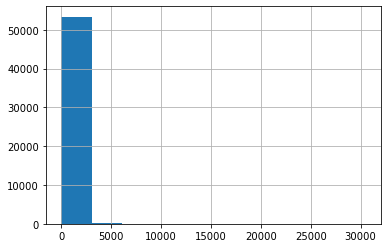

In [253]:
clean_df['population'].hist() #needs to be scaled likely, very skewed

<AxesSubplot:>

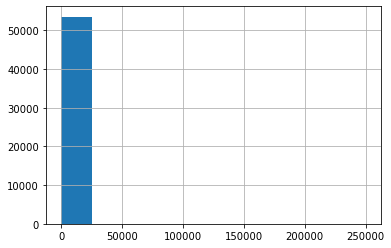

In [254]:
clean_df['amount_tsh'].hist() #needs to be scaled likely, very skewed

In [255]:
clean_df.corr() #almost all categorical but looking at correlations anyway 

,id,amount_tsh,population,permit,binary_status
id,1.000000,-0.006130,-0.001574,0.000314,-0.001373
amount_tsh,-0.006130,1.000000,0.015299,0.030253,0.057345
population,-0.001574,0.015299,1.000000,-0.038569,0.011763
permit,0.000314,0.030253,-0.038569,1.000000,0.029007
binary_status,-0.001373,0.057345,0.011763,0.029007,1.000000


# Modeling!
Now that we have completed exploring that dataset and cleaning we can begin our modelling process. 
### Dummy Model
- We are going to start by creating a dummy model. This will be the model we will be improving upon.
- To start we need to create a test set and a training set for the models. 

In [256]:
X = clean_df.drop(['binary_status', 'id'], axis=1)
y = clean_df['binary_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#splitting 75/25 based on the default splits

In [257]:
#looking if there is class imbalence in the y
y_train.value_counts(normalize=True)
#normalize = true to get the percentage breakdown instead of the values

1    0.62649
0    0.37351
Name: binary_status, dtype: float64

There is no glaring class imbalence based on this percentage breakdown so continuing with model. 

In [258]:
#creating a dummy model
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dum_preds = dummy_model.predict(X_train)

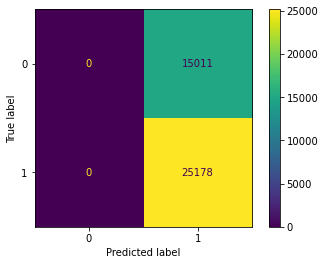

In [259]:
#plotting confusion matrix to show what our model is predicting vs. true
plot_confusion_matrix(dummy_model, X_train, y_train);

Checking f1 score of the dummy model since this is what we will be trying to improve upon for each model as explained earlier. To reiterate, the reason we care about the f1 score in this case is because it includes both the recall and precision score in it and therefore factors in false negatives as well as false positives which is important for the purposes of this business case. 

In [260]:
f1_score(y_train, dummy_model.predict(X_train)) 
#this score is not terrible but definintely needs to be improved upon

0.7703581317790322

In [360]:
cv_dummy = ModelWithCV(dummy_model, 'dummy model', X_train, y_train)
cv_dummy.print_cv_summary() 

CV Results for `dummy model` model:
            0.77036 ± 0.00004 f1 score
        


### Dealing with Categorical Variables and Scaling Numerics
As noted earlier, we have mostly categorical variables within this data set and will therefore need to deal with them before using them in a model. Additionally, we need to scale our numeric variables if we end up using a logistic regression model.
- We will be scaling numerics through StandardScalar
- We will be dealing with categorical through using OneHotEncoder ('OHE').

These two methods of dealing with variables are going to be implemented through the use of a pipeline for ease of use in each model and to avoid making errors between models. This will help with consistency across all. 

In [261]:
X.dtypes #looking into data types of X 

amount_tsh                int64
funder                   object
installer                object
region_code              object
district_code            object
population                int64
permit                    int64
extraction_type_class    object
management               object
quality_group            object
quantity_group           object
source_type              object
source_class             object
waterpoint_type_group    object
dtype: object

Creating two lists:
- scale: includes only the numeric variables
- cat: includesonly the categorical variables

In [262]:
scale = ['population', 'amount_tsh']
cat = ['funder', 'installer', 'region_code',
           'district_code', 'extraction_type_class', 'management', 'quality_group',
           'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

Creating subpipes to standard scale and one hot encode numeric and categorical columns respectively.


In [263]:
subpipe_numeric = Pipeline(steps=[('ss', StandardScaler())])
subpipe_categorical = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown= 'ignore'))])

In [264]:
#instantiating a column transformer and assigning it to variable CT
CT = ColumnTransformer(transformers=[('subpipe_numeric', subpipe_numeric, scale),
                                         ('subpipe_categorical', subpipe_categorical, cat)],
                           remainder='passthrough')

In [265]:
#fiting the column transformer and assigning it to variable ct_transform
ct_transform = CT.fit_transform(X_train)

In order to visualize the column transfromer working, printed out below the ct_transform which shows the pipeline creates a dataframe of 3417 since we have now OneHotEncoded all categorical variables. Pretty cool! 

In [266]:
pd.DataFrame(ct_transform) #showing one hot encode!! 

,0,1,2,3,4,5,6,7,8,9,...,3407,3408,3409,3410,3411,3412,3413,3414,3415,3416
0,-0.383591,0.028459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.029582,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.548645,0.067755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.385668,-0.128724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40184,-0.383591,-0.050132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
40185,0.341020,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40186,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40187,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We can now begin working on models that are not our dummy model. To start, I created a logistic regression.

### Logistic model

In [267]:
logreg_model= Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(random_state=42))])
logreg_model.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numeric',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['population', 'amount_tsh']),
                                                 ('subpipe_categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'region_code',
                                                   'district_code',
                                              

In [268]:
f1_score(y_train, logreg_model.predict(X_train))

0.8670668475533831

This f1 score is an improvement on the dummy model but lets look at a confusion matrix to understand more. 

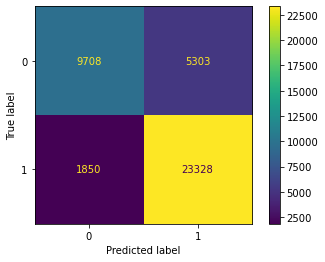

In [269]:
plot_confusion_matrix(logreg_model, X_train, y_train)

In [270]:
cv_log = ModelWithCV(logreg_model, 'log_model', X_train, y_train)
cv_log.print_cv_summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

CV Results for `log_model` model:
            0.85955 ± 0.00111 f1 score
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This CV result is showing that the model is not incredibly ovefit since it is very close to the f1 score from our training data. However, in thinking more on the problem we are trying to address I decided to pivot to a decision tree to be able to more accurately predict our classes. A decision tree will be much better for the this dataset since the decision tree is a non-parametric method and it can handle high-dimensional data with a higher level of accuracy. 

### Decision Tree
We will be using the same pipeline as above but this time on Decision tree! Starting off with the default parameters.

Decision Model 1

In [271]:
decision_model = Pipeline(steps=[('ct', CT),
                            ('decision_tree', DecisionTreeClassifier(random_state=42))])
decision_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numeric',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['population', 'amount_tsh']),
                                                 ('subpipe_categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'region_code',
                                                   'district_code',
                                              

In [272]:
f1_score(y_train, decision_model.predict(X_train)) #much closer to 1

0.9494201728652715

This score is much better than our earlier scores! However, decision trees are very prone to being overfit so we must cross validate to see how this score compares to "unseen" data. 

In [273]:
cv_decision = ModelWithCV(decision_model, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `decision_model` model:
            0.85385 ± 0.00262 f1 score
        


Based on these CV results we can conclude that our model is overfit and therefore are going to try to reduce the overfitness. We do this by first adjusting the max_depth. 

Decision Model 2: adjusting max depth

In [274]:
decision_model2 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, max_depth=5 ))])
decision_model2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numeric',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['population', 'amount_tsh']),
                                                 ('subpipe_categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'region_code',
                                                   'district_code',
                                              

In [275]:
f1_score(y_train, decision_model2.predict(X_train))  

0.8370890822381594

This score went down a lot but lets see if it still as overfit! 

In [276]:
cv_decision = ModelWithCV(decision_model2, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary() #much less overfit! but low score

CV Results for `decision_model` model:
            0.83770 ± 0.00258 f1 score
        


This tree isn't overfit!! However, the f1 score is low and could use improvement. We are going to test out some additional parameters to see if we can tune this tree to be less overfit overall and a higher f1 score. 

Decision Model 3: Adjust min_samples_leaf

In [277]:
decision_model3 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, min_samples_leaf= 5))])
decision_model3.fit(X_train, y_train)
f1_score(y_train, decision_model3.predict(X_train)) ##went back up

0.9016438036762134

In [278]:
cv_decision = ModelWithCV(decision_model3, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary() #higher cv but still very overfit.

CV Results for `decision_model` model:
            0.85719 ± 0.00162 f1 score
        


Decision Model 4: Incorporating min sample leaf + increasing max depth

In [279]:
decision_model4 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, min_samples_leaf= 5, 
                                                   max_depth = 7))])
decision_model4.fit(X_train, y_train)
f1_score(y_train, decision_model4.predict(X_train)) ##went back up

0.8504317913068405

In [280]:
cv_decision = ModelWithCV(decision_model4, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary() #cv went down but not as overfit

CV Results for `decision_model` model:
            0.84578 ± 0.00254 f1 score
        


Going to perform a grid search now to search for optimal hyperperamters!

Grid Search
Including:
- max depth
- min samples leaf

Looking into parameters to see what they are called for the purposes of the grid search.

In [281]:
decision_model.get_params().keys() #checking out the parameters that can be used

dict_keys(['memory', 'steps', 'verbose', 'ct', 'decision_tree', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__subpipe_numeric', 'ct__subpipe_categorical', 'ct__subpipe_numeric__memory', 'ct__subpipe_numeric__steps', 'ct__subpipe_numeric__verbose', 'ct__subpipe_numeric__ss', 'ct__subpipe_numeric__ss__copy', 'ct__subpipe_numeric__ss__with_mean', 'ct__subpipe_numeric__ss__with_std', 'ct__subpipe_categorical__memory', 'ct__subpipe_categorical__steps', 'ct__subpipe_categorical__verbose', 'ct__subpipe_categorical__ohe', 'ct__subpipe_categorical__ohe__categories', 'ct__subpipe_categorical__ohe__drop', 'ct__subpipe_categorical__ohe__dtype', 'ct__subpipe_categorical__ohe__handle_unknown', 'ct__subpipe_categorical__ohe__sparse', 'decision_tree__ccp_alpha', 'decision_tree__class_weight', 'decision_tree__criterion', 'decision_tree__max_depth', 'decision_tree__max_features', 'decision_tree__max_leaf_nodes', 'decision_tree__

In [284]:
tree = {'decision_tree__max_depth': range(1, 10),
         'decision_tree__min_samples_leaf':range(1,5)}
                 
gs_dt = GridSearchCV(
    estimator = decision_model, 
    param_grid = tree, cv=5, verbose= 3, scoring = 'f1') 

#set for no n_jobs but otherwise -3 and see what happens

In [285]:
gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=1 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=1, score=0.815, total=   2.0s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=1 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=1, score=0.816, total=   1.9s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=1 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=1, score=0.815, total=   1.8s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=1 ...
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=1, score=0.815, total=   1.8s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=1 ...
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=1, score=0.816, total=   1.9s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=2 ...
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=2, score=0.815, total=   1.8s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=2 ...
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=2, score=0.816, total=   1.8s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=2 ...
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_leaf=2, score=0.815, total=   1.8s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_leaf=2 ..

[CV]  decision_tree__max_depth=3, decision_tree__min_samples_leaf=3, score=0.836, total=   3.4s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_leaf=3 ...
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_leaf=3, score=0.836, total=   3.3s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_leaf=3 ...
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_leaf=3, score=0.839, total=   3.4s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_leaf=4 ...
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_leaf=4, score=0.838, total=   3.3s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_leaf=4 ...
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_leaf=4, score=0.839, total=   3.3s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_leaf=4 ...
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_leaf=4, score=0.836, total=   3.4s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_leaf=4 ..

[CV]  decision_tree__max_depth=6, decision_tree__min_samples_leaf=1, score=0.837, total=   4.4s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_leaf=1 ...
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_leaf=1, score=0.839, total=   5.2s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_leaf=1 ...
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_leaf=1, score=0.839, total=   4.8s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_leaf=2 ...
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_leaf=2, score=0.844, total=   4.6s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_leaf=2 ...
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_leaf=2, score=0.847, total=   4.8s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_leaf=2 ...
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_leaf=2, score=0.837, total=   4.5s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_leaf=2 ..

[CV]  decision_tree__max_depth=8, decision_tree__min_samples_leaf=3, score=0.848, total=   5.2s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_leaf=3 ...
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_leaf=3, score=0.850, total=   7.9s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_leaf=3 ...
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_leaf=3, score=0.854, total= 9.0min
[CV] decision_tree__max_depth=8, decision_tree__min_samples_leaf=4 ...
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_leaf=4, score=0.854, total=   5.0s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_leaf=4 ...
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_leaf=4, score=0.851, total=   5.0s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_leaf=4 ...
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_leaf=4, score=0.847, total=   4.9s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_leaf=4 ..

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 27.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numeric',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['population',
                                                                          'amount_tsh']),
                                                                        ('subpipe_categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                     

In [286]:
gs_dt.best_params_

{'decision_tree__max_depth': 9, 'decision_tree__min_samples_leaf': 4}

Decision model 5: using grid search parameters

In [287]:
decision_model5 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, min_samples_split= 4,
                                                   max_depth = 9))])
decision_model5.fit(X_train, y_train)
f1_score(y_train, decision_model5.predict(X_train)) ##went back up

0.861718140766399

In [288]:
cv_decision = ModelWithCV(decision_model5, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `decision_model` model:
            0.85591 ± 0.00259 f1 score
        


After digging into decision tree, I decided to run a random forest since it looks at the data with more complexity and could lead to a higher score. 

### Random Forest

Random forest model 1: Default values (the untuned tree)

In [289]:
rf_model = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(
                            random_state=1))])
rf_model.fit(X_train, y_train)
f1_score(y_train, rf_model.predict(X_train))

0.949935715120583

In [290]:
cv_rf = ModelWithCV(rf_model, 'random_forest', X_train, y_train)
cv_rf.print_cv_summary()

CV Results for `random_forest` model:
            0.87254 ± 0.00138 f1 score
        


This model has a high f1 score but is very overfit based on the CV results. Attempting to change this through adjusting hyper parameters below and seeing how they effect the f1 score and cross validation f1 score i.e. how the model would look on unseen data.

Random forest model 2: Trying out a tree with max samples .3 to reduce overfit

In [291]:
rf_model2 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(max_features='sqrt',
                            max_samples=0.3,
                            random_state=1))])
rf_model2.fit(X_train, y_train)
f1_score(y_train, rf_model2.predict(X_train))

0.9229916685775433

In [292]:
cv_rf = ModelWithCV(rf_model2, 'random_forest', X_train, y_train)
cv_rf.print_cv_summary() #better score!!!

CV Results for `random_forest` model:
            0.87949 ± 0.00111 f1 score
        


This model is less overfit but believe I can do better. Attempting to adjust the max_depth parameter instead. 

Random forest model 3: adjusting max depth

In [293]:
rf_model3 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(random_state=1,
                                                                     max_depth = 5))])
rf_model3.fit(X_train, y_train)
f1_score(y_train, rf_model3.predict(X_train))

0.7849668615984405

In [294]:
cv_rf = ModelWithCV(rf_model3, 'random_forest', X_train, y_train)
cv_rf.print_cv_summary()

CV Results for `random_forest` model:
            0.78174 ± 0.00515 f1 score
        


Uh oh! Model seems underfit drastically here. Predicting almost as badly as thhe dummy model. Will have to keep iterating.

Random Forest Model 4: increasing max samples and seeing the effect

In [295]:
rf_model4 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(max_features='sqrt',
                            max_samples=0.5,
                            random_state=1))])
rf_model4.fit(X_train, y_train)
f1_score(y_train, rf_model4.predict(X_train))

0.9371829736349785

In [296]:
cv_decision = ModelWithCV(rf_model4, 'random_forest', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `random_forest` model:
            0.87826 ± 0.00261 f1 score
        


This model resulted in a better f1 score than model 2 however worse score when crossvalidating implying still very overfit so going back to dealing with max depth but increasing the depth by much more than 5 

Random Forest Model 5: Increasing max_depth and seeing how this effects

In [321]:
 rf_model5 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(max_features='sqrt',
                            max_depth = 30,
                            random_state=1))])
rf_model5.fit(X_train, y_train)
f1_score(y_train, rf_model5.predict(X_train))

0.90219852457819

In [322]:
cv_rf = ModelWithCV(rf_model5, 'random_forest', X_train, y_train)
cv_rf.print_cv_summary()

CV Results for `random_forest` model:
            0.87730 ± 0.00180 f1 score
        


This model definitely did a lot better than our other depth focused model but going to now do a grid search to hopefully ifnd the optimal parameters! 

Grid Search on Random Forest

In [107]:
rf_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'random_forest', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__subpipe_numeric', 'ct__subpipe_categorical', 'ct__subpipe_numeric__memory', 'ct__subpipe_numeric__steps', 'ct__subpipe_numeric__verbose', 'ct__subpipe_numeric__ss', 'ct__subpipe_numeric__ss__copy', 'ct__subpipe_numeric__ss__with_mean', 'ct__subpipe_numeric__ss__with_std', 'ct__subpipe_categorical__memory', 'ct__subpipe_categorical__steps', 'ct__subpipe_categorical__verbose', 'ct__subpipe_categorical__ohe', 'ct__subpipe_categorical__ohe__categories', 'ct__subpipe_categorical__ohe__drop', 'ct__subpipe_categorical__ohe__dtype', 'ct__subpipe_categorical__ohe__handle_unknown', 'ct__subpipe_categorical__ohe__sparse', 'random_forest__bootstrap', 'random_forest__ccp_alpha', 'random_forest__class_weight', 'random_forest__criterion', 'random_forest__max_depth', 'random_forest__max_features', 'random_forest__max_l

In [306]:
tree = {'random_forest__min_samples_leaf':range(1,5),
       'random_forest__max_samples': (.3),
       'random_forest__max_depth':range(1,10)}
                                              
gs_rf = GridSearchCV(
    estimator = rf_model, 
    param_grid = tree, cv=5, verbose=3, scoring = 'f1', n_jobs = -3)

In [117]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed: 10.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numeric',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['population',
                                                                          'amount_tsh']),
                                                                        ('subpipe_categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                     

In [118]:
gs_rf.best_params_

{'random_forest__max_depth': 9,
 'random_forest__max_samples': 0.3,
 'random_forest__min_samples_leaf': 1}

In [119]:
rf_model6 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(max_features='sqrt',
                            max_samples=0.3, max_depth = 9, min_samples_leaf = 1,
                            random_state=1))])
rf_model6.fit(X_train, y_train)
f1_score(y_train, rf_model6.predict(X_train))

0.8166800636493381

In [120]:
cv_decision = ModelWithCV(rf_model6, 'random_forest', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `random_forest` model:
            0.81966 ± 0.00488 f1 score
        


After doing this grid search, noted that it was pulling out the max range for each hyperparameter which likely means I need to increase my parameter ranges. Will now run an additional grid search to see if this helps. 

2nd Grid Search on Random Forest 

In [349]:
tree = {'random_forest__max_samples':[.4,.5,.6],
       'random_forest__max_depth':range(30,40)}
                                              
gs_rf2 = GridSearchCV(
    estimator = rf_model, 
    param_grid = tree, cv=5, verbose=3, scoring = 'f1', n_jobs = -3)

In [350]:
gs_rf2.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-3)]: Done 150 out of 150 | elapsed: 42.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numeric',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['population',
                                                                          'amount_tsh']),
                                                                        ('subpipe_categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                     

In [351]:
gs_rf2.best_params_

{'random_forest__max_depth': 39, 'random_forest__max_samples': 0.5}

In [352]:
rf_model7 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier
                             (max_depth = 39 , max_samples=.5, random_state=1))])
rf_model7.fit(X_train, y_train)
f1_score(y_train, rf_model7.predict(X_train))

0.9130072107809517

In [353]:
cv_rf2 = ModelWithCV(rf_model7, 'random_forest_final', X_train, y_train)
cv_rf2.print_cv_summary()

CV Results for `random_forest_final` model:
            0.88144 ± 0.00150 f1 score
        


Would like to create a grid search with higher level of depth but going to stop here for now. This is going to be used as our final model since is has the highest f1 score! Will now use this model to create predictions and glean insights! 

## Final Model Predictions:
- Using the rf_model7 since it had the highest cross validation score
- Will now be using the unseen testing and testing for real how my model does! 

In [354]:
final_model = rf_model7

In [355]:
print('Training:',f1_score(y_train, final_model.predict(X_train)))
print('Testing:', f1_score(y_test, final_model.predict(X_test)))

Training: 0.9130072107809517
Testing: 0.8748043818466353


Showing confusion model on testing data. 

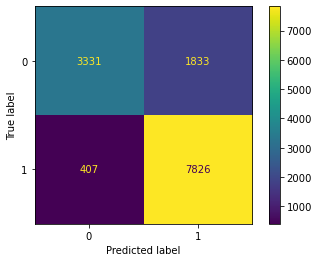

In [356]:
plot_confusion_matrix(final_model, X_test, y_test);

This was a great improvement from the dummy model since the dummy predicted all wells as functional.

Graphing F1 Score Baseline vs Final Model

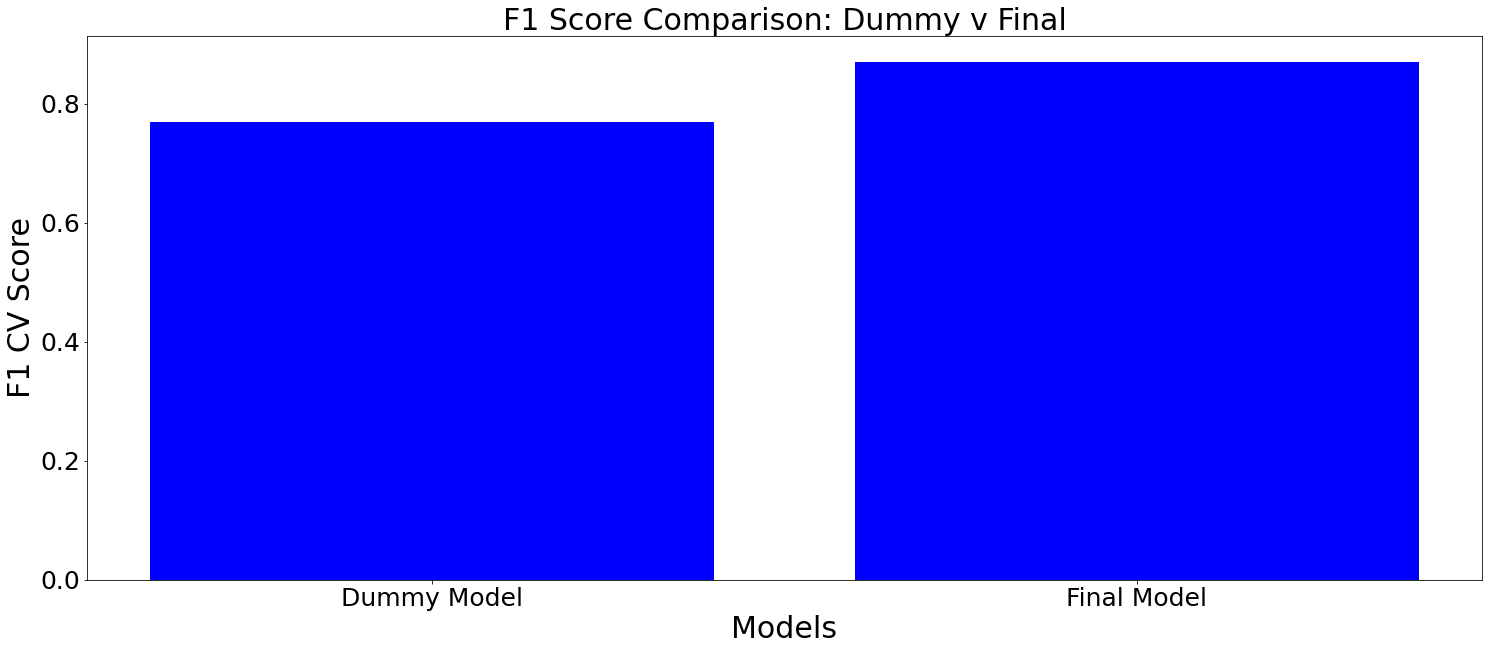

In [426]:
x = ['Dummy Model', 'Final Model']
y = [.77, .87]

fig, ax = plt.subplots(figsize=(25,10))
plt.bar(x,y, color = 'blue')

ax.set_title("F1 Score Comparison: Dummy v Final",fontsize= 30 )

plt.xlabel('Models', fontsize=30)
ax.set_ylabel("F1 CV Score", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25 );

Although it does not look like the final model improved that much a 10% is actually a major shift when understanding what the dummy model was predicting. We went from not predicting any well as non-functional to accurately predicting 3.3k as non functional. This will be hugely valuable for saving time and money for Tanzania! 

# Feature Importance
Digging a bit more into which feature are important below and where to focus for next steps and the actual well reperations. The features below highlight which ones have the most impact of the predction modeling. 

In [451]:
#looking at the length of the final model
len(final_model['random_forest'].feature_importances_)

3417

In [452]:
feature_names = ['population', 'amount_tsh']
ohe_feature_names = CT.named_transformers_['subpipe_categorical']['ohe'].get_feature_names().tolist()
feature_names.extend(ohe_feature_names)
feature_names.append('permit')
len(feature_names) #checking to make sure this incorporates all the columns

3417

In [453]:
#creating a list of the feature importances
feature_importance = []

for feature, fi, in zip(feature_names, final_model['random_forest'].feature_importances_):
    feature_importance.append((feature,fi))
    
feature_importance  

[('population', 0.09722602356322717),
 ('amount_tsh', 0.054109669757040034),
 ('x0_0', 0.0009679811656009965),
 ('x0_A/co Germany', 7.070287462270299e-05),
 ('x0_Aar', 6.230531749891627e-05),
 ('x0_Abas Ka', 6.62844086335201e-06),
 ('x0_Abasia', 5.4883759220698194e-05),
 ('x0_Abc-ihushi Development Cent', 1.8464583387810914e-05),
 ('x0_Abd', 2.0065008503711087e-05),
 ('x0_Abdala', 8.080177953390494e-07),
 ('x0_Abs', 2.9812651402869213e-06),
 ('x0_Aco/germany', 1.067485485503291e-05),
 ('x0_Acord', 6.0195602349096e-06),
 ('x0_Acra', 7.011360822770976e-05),
 ('x0_Action Aid', 1.2168970486365257e-05),
 ('x0_Action Contre La Faim', 3.0367758953782025e-05),
 ('x0_Adap', 3.173906890284656e-05),
 ('x0_Adb', 0.001099401223473289),
 ('x0_Adf', 6.309133092242248e-05),
 ('x0_Adp', 6.841726644732295e-05),
 ('x0_Adp Bungu', 1.7137775023275906e-06),
 ('x0_Adp Mombo', 4.5630891968711194e-05),
 ('x0_Adp/w', 1.7104447819630127e-05),
 ('x0_Adra', 0.0010132849380802636),
 ('x0_Af', 4.142922174058516e-05)

In [455]:
feature_importance.sort(key = lambda x: x[1], reverse = True)

In [456]:
feature_importance[:10] #looking at the top 10 feature importances

[('x7_dry', 0.11358672852523698),
 ('population', 0.09722602356322717),
 ('x7_enough', 0.05499708710523547),
 ('amount_tsh', 0.054109669757040034),
 ('x10_other', 0.045758044277973024),
 ('x4_other', 0.042201917758333506),
 ('x7_insufficient', 0.02268333031692741),
 ('x4_handpump', 0.018261415715245883),
 ('x10_hand pump', 0.016288380808936954),
 ('x4_gravity', 0.015432760767001891)]

In [457]:
#creating a dataframe for the top 10 features
features_df = pd.DataFrame(feature_importance[:10])   
features_df.columns = ['Features', 'Importances']
features_df

,Features,Importances
0,x7_dry,0.113587
1,population,0.097226
2,x7_enough,0.054997
3,amount_tsh,0.054110
4,x10_other,0.045758
5,x4_other,0.042202
6,x7_insufficient,0.022683
7,x4_handpump,0.018261
8,x10_hand pump,0.016288
9,x4_gravity,0.015433


In [394]:
#renaming all the features to graph
features_df['Features'][0] = 'Quantity: Dry'
features_df['Features'][1] = 'Population'
features_df['Features'][2] = 'Quantity: Enough'
features_df['Features'][3] = 'Amount of Water'
features_df['Features'][4] = 'Waterpoint Type: Other'
features_df['Features'][5] = 'Extraction Type: Other'
features_df['Features'][6] = 'Quantity: Insufficient'
features_df['Features'][7] = 'Extraction Type: Handpump'
features_df['Features'][8] = 'Waterpoint Type: Hand Pump'
features_df['Features'][9] = 'Extraction Type: Gravity'



<ipython-input-394-b68a4139f72b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['Features'][0] = 'Quantity: Dry'
<ipython-input-394-b68a4139f72b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['Features'][1] = 'Population'
<ipython-input-394-b68a4139f72b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['Features'][2] = 'Quantity: Enough'
<ipython-input-394-b68a4139f72b>:4: SettingWithCopyWarning

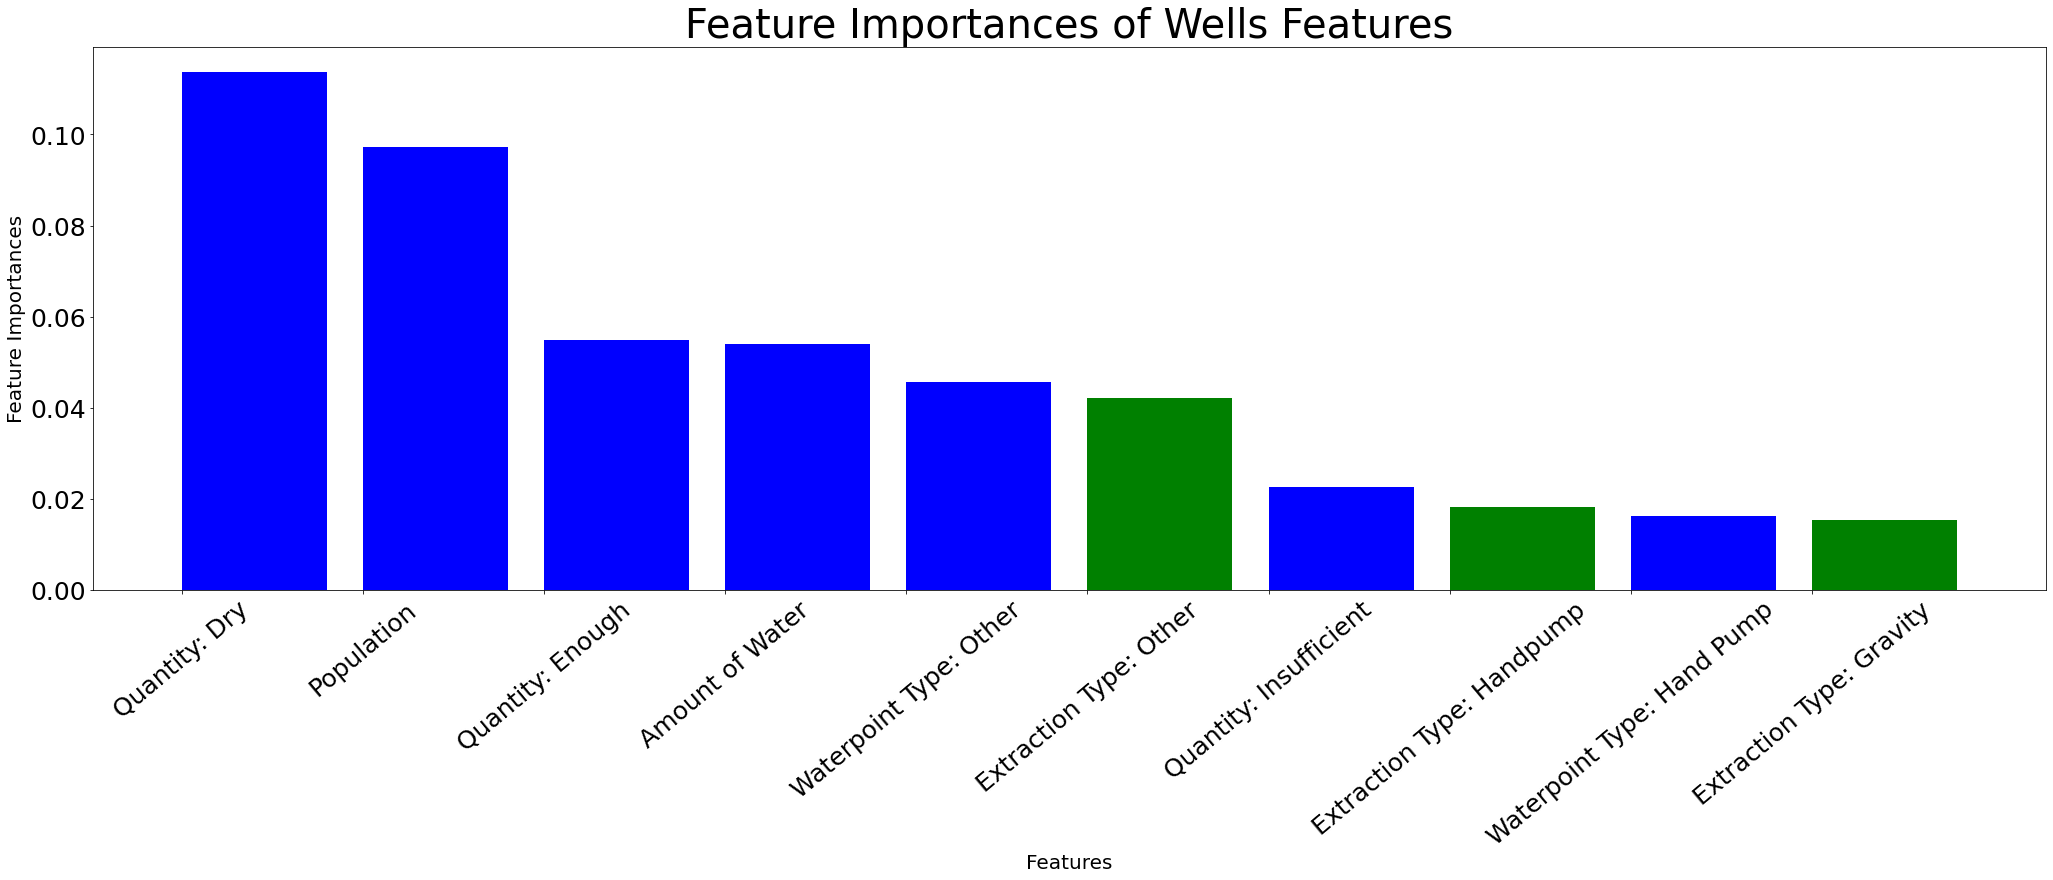

In [431]:
#Graphing the feature importances 
x = features_df['Features'][:10]
y = features_df['Importances'][:10]

fig, ax = plt.subplots(figsize=(35,10))
plt.bar(x,y, color=['blue', 'blue', 'blue', 'blue', 'blue', 
                   'green', 'blue', 'green', 'blue', 'green'], 
       align = 'edge')

ax.set_title("Feature Importances of Wells Features",fontsize=40 )
plt.xlabel('Features', fontsize=20)
ax.set_ylabel("Feature Importances", fontsize=20)
plt.xticks(fontsize=25, rotation = 40)
plt.yticks(fontsize=25);


As you can see on the bar chart displayed here the top features having the largest impact on the predictability of whether a well is functional or not is:
- population, which makes sense 
- water quality
- the amount of water in the well
- extraction type 

These are important to know about since it could give inference into when fixing well or building new wells. The extraction type in specific could be very benefitcial when looking into fixing the wells for example if the extraction device should be converted to something else like a hand pump instead of relying on gravity which would be another type.  

---

# Conclusion and Next Steps

With this model the government in Tanzania should be able to spend much less money and time looking into individual wells to find out if functional or not and should also be able to glean insights as to maybe how to build and where to place future wells. 

As part of the next steps I would do a deeper dive into a few of these features, particularly the extraction feature. I would do some further tuning of my model as well to increase the f1 score.  Additionally, I would maybe look into other locations in Africa that are facing similar issues and gather data and insights there as well. 

Thank you!